In [1]:
import pandas as pd
import numpy as np
from functools import reduce

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Datos y funciones de ayuda

In [2]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)

from src.utils import get_data, prepare_data, merge_data, split_data_year

In [3]:
paths = {
        'paes': '../Datos/paes_encrypted.xlsx',
        'sepa': '../Datos/df_pruebas_sepa.csv',
        'indicadores': '../Datos/df_indicadores.csv',
        'bloom': '../Datos/df_taxonomia.csv',
        'dificultad': '../Datos/df_avg_diff_scores_agg.csv'
    }
df, _, _ = get_data(type='sepa', paths=paths)

In [4]:
df_train, df_test = split_data_year(df, year=2025)
target_columns = ['C. Lectora', 'Matemática', 'Historia', 'Ciencias', 'M2']
datasets = {}
for target in target_columns:
    X_train, _, y_train, _ = prepare_data(df_train, target_column=target, test_size=0.0, verbose=True)
    X_test, _, y_test, _ = prepare_data(df_test, target_column=target, test_size=0.0, verbose=True)
    datasets[target] = (X_train, X_test, y_train, y_test)

Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 223
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 100
Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 223
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 100
Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 158
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 72
Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 127
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 25
Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 156
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 37


In [7]:
# Model creation and evaluation functions
def create_model(model_type='random_forest', **kwargs):
    if model_type == 'random_forest':
        return RandomForestRegressor(**kwargs)
    elif model_type == 'bayesian_ridge':
        return BayesianRidge(**kwargs)
    elif model_type == 'linear_regression':
        return LinearRegression(**kwargs)
    elif model_type == 'gradient_boosting':
        return GradientBoostingRegressor(**kwargs)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
def train_and_evaluate(model, X_train, y_train, X_test=None, y_test=None):
    model.fit(X_train, y_train)
    if X_test is not None and y_test is not None:
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"Root Mean Squared Error: {rmse:.2f}, R^2 Score: {r2:.2f}")
    else:
        y_pred = model.predict(X_train)
        print("Model trained on training data only.")
    return model, y_pred
def plot_predictions(y_true, y_pred, title='Model Predictions'):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.grid()
    plt.show()

from sklearn.model_selection import GridSearchCV

# define function that finetunes the model, given a set of hyperparameters
def finetune_model(model, X_train, y_train, param_grid, cv=3):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print("Best parameters found: ", grid_search.best_params_)
    return grid_search.best_params_

from sklearn.ensemble import StackingRegressor
def create_stacked_model(base_models, final_estimator):
    return StackingRegressor(estimators=base_models, final_estimator=final_estimator, cv=5)

def train_stacked_model(stacked_model, X_train, y_train, X_test=None, y_test=None):
    stacked_model.fit(X_train, y_train)
    if X_test is not None and y_test is not None:
        y_pred = stacked_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"Stacked Model - Root Mean Squared Error: {rmse:.2f}, R^2 Score: {r2:.2f}")
    else:
        y_pred = stacked_model.predict(X_train)
        print("Stacked model trained on training data only.")
    return stacked_model, y_pred

def plot_feature_importances(model, feature_names, title='Feature Importances'):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        raise ValueError("Model does not have feature importances or coefficients.")
    
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
    plt.tight_layout()
    plt.show()

def plot_stacked_feature_importances(stacked_model, X_train, title='Importancia de Variables para Stacked Model'):
    coefs = stacked_model.final_estimator_.coef_
    feature_names = X_train.columns
    estimators = stacked_model.estimators_
    importances = np.zeros(len(feature_names))
    # get weighted importances from base models using their coefficients
    for i, model in enumerate(estimators):
        if hasattr(model, 'feature_importances_'):
            importances += model.feature_importances_ * coefs[i]
        elif hasattr(model, 'coef_'):
            importances += np.abs(model.coef_) * coefs[i]
    indices = np.argsort(importances)[::-1]
    # Plotting the feature importances
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
    plt.tight_layout()
    plt.show()

## Predicción de puntajes C. Lectora

### Crear y entrenar un Random Forest

Root Mean Squared Error: 70.70, R^2 Score: 0.43


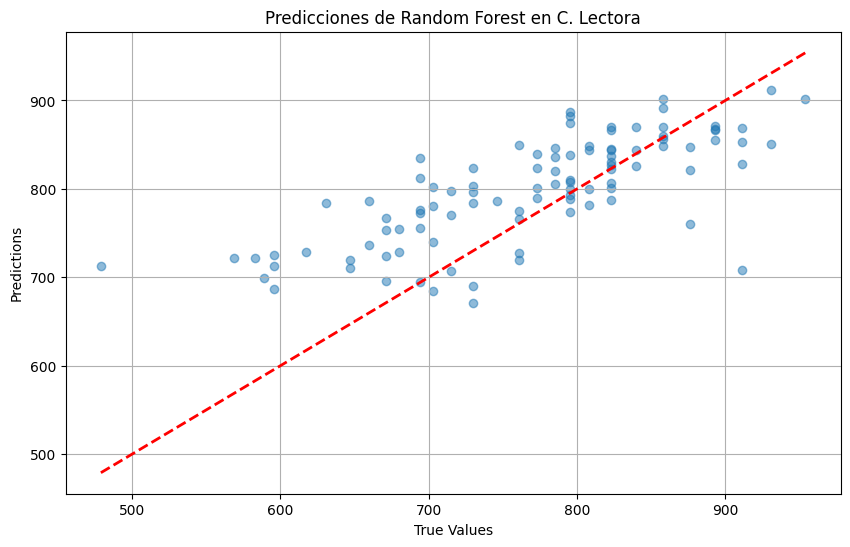

In [132]:
target_column = 'C. Lectora'
X_train, X_test, y_train, y_test = datasets[target_column]
model = create_model(model_type='random_forest', n_estimators=100, random_state=42)
model, y_pred = train_and_evaluate(model, X_train, y_train, X_test, y_test)
plot_predictions(y_test, y_pred, title=f'Predicciones de Random Forest en {target_column}')


### Crear y entrenar el Stacking Regressor

Stacked Model - Root Mean Squared Error: 72.06, R^2 Score: 0.40


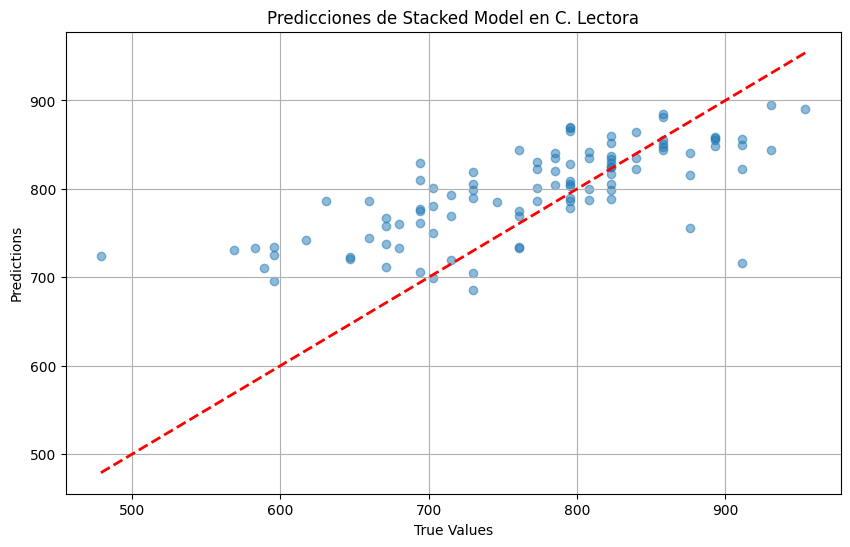

In [131]:
# Ahora vamos a crear un modelo apilado con Random Forest y Gradient Boosting como modelos base, y Bayesian Ridge como modelo final.
# es decir, la predicción final se hará con Bayesian Ridge, que tomará las predicciones de los modelos base como entradas.
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=25, random_state=42))
]
final_estimator = BayesianRidge()
stacked_model = create_stacked_model(base_models, final_estimator)
stacked_model, y_pred_stacked = train_stacked_model(stacked_model, X_train, y_train, X_test, y_test)
plot_predictions(y_test, y_pred_stacked, title=f'Predicciones de Stacked Model en {target_column}')

### Graficamos la importancia de las variables

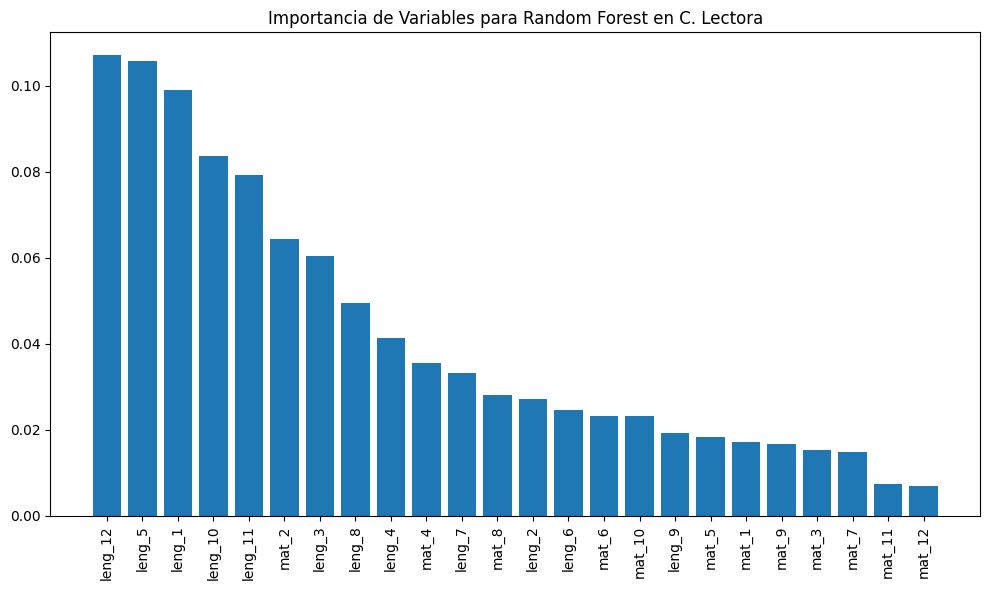

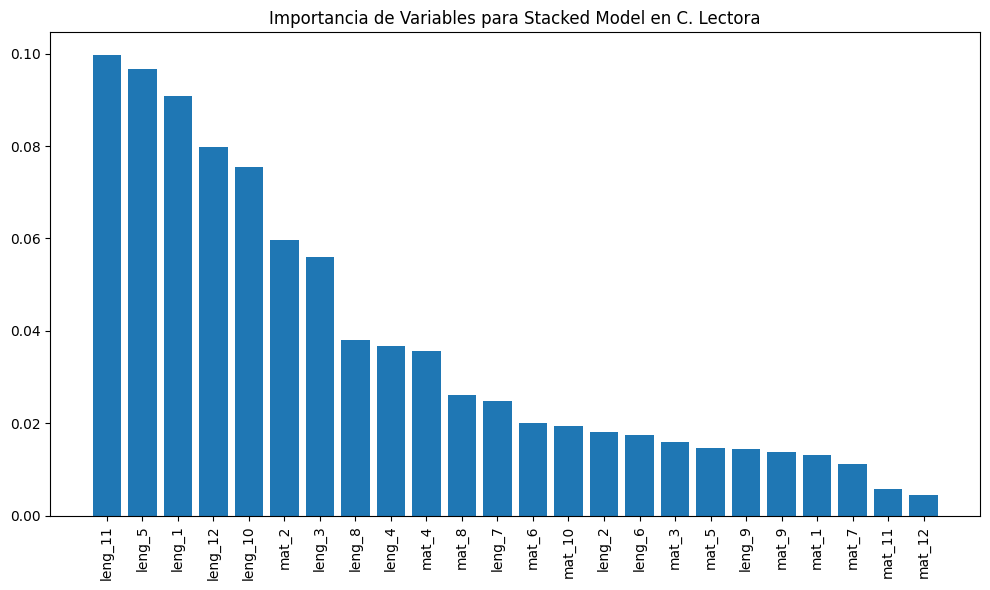

In [126]:
# Plot feature importances for the random forest model
plot_feature_importances(model, X_train.columns, title=f'Importancia de Variables para Random Forest en {target_column}')
# Plot feature importances for the stacked model
plot_stacked_feature_importances(stacked_model, X_train, title=f'Importancia de Variables para Stacked Model en {target_column}')


### Sacar variables de poca importancia

In [134]:
N_vars = 10 # al ojo cuántas son las más importantes de los gráficos
X_train, X_test, y_train, y_test = datasets[target_column]
important_columns_rf = X_train.columns[np.argsort(model.feature_importances_)[::-1][:N_vars]]
print(f"Las {N_vars} variables más importantes para el modelo de Random Forest en {target_column} son: {important_columns_rf.tolist()}")
coefs = stacked_model.final_estimator_.coef_
feature_names = X_train.columns
estimators = stacked_model.estimators_
importances = np.zeros(len(feature_names))
# get weighted importances from base models using their coefficients
for i, model in enumerate(estimators):
    if hasattr(model, 'feature_importances_'):
        importances += model.feature_importances_ * coefs[i]
    elif hasattr(model, 'coef_'):
        importances += np.abs(model.coef_) * coefs[i]
indices = np.argsort(importances)[::-1]
important_columns_stacked = feature_names[indices][:N_vars]
print(f"Las {N_vars} variables más importantes para el modelo apilado en {target_column} son: {important_columns_stacked.tolist()}")

Las 10 variables más importantes para el modelo de Random Forest en C. Lectora son: ['leng_11', 'leng_5', 'leng_1', 'leng_10', 'mat_2', 'leng_3', 'mat_4', 'leng_4', 'leng_12', 'mat_8']
Las 10 variables más importantes para el modelo apilado en C. Lectora son: ['leng_11', 'leng_5', 'leng_1', 'leng_12', 'leng_10', 'mat_2', 'leng_3', 'leng_8', 'leng_4', 'mat_4']


Root Mean Squared Error: 70.91, R^2 Score: 0.42


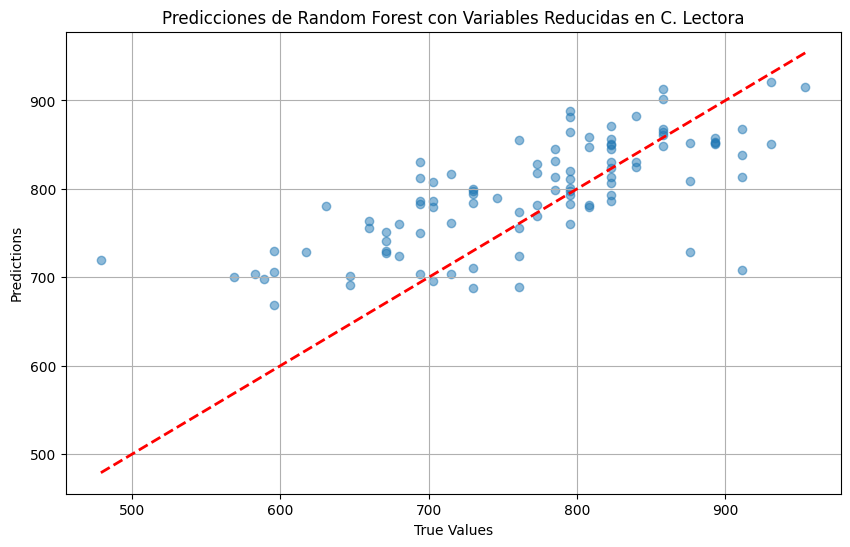

In [135]:
total_columns = important_columns_rf.tolist()
X_train_reduced = X_train[total_columns]
X_test_reduced = X_test[total_columns] if X_test is not None else None
y_train_reduced = y_train
y_test_reduced = y_test
model_reduced = create_model(model_type='random_forest', n_estimators=50, random_state=42)
model_reduced, y_pred_reduced = train_and_evaluate(model_reduced, X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)
plot_predictions(y_test_reduced, y_pred_reduced, title=f'Predicciones de Random Forest con Variables Reducidas en {target_column}')

Stacked Model - Root Mean Squared Error: 73.38, R^2 Score: 0.38


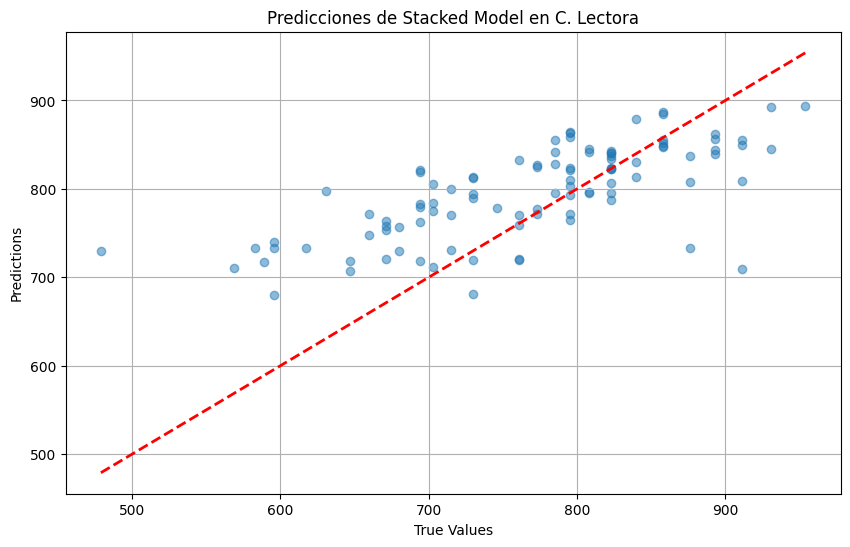

In [136]:
total_columns = important_columns_stacked.tolist()
X_train_reduced = X_train[total_columns]
X_test_reduced = X_test[total_columns] if X_test is not None else None
y_train_reduced = y_train
y_test_reduced = y_test
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=20, random_state=42))
]
final_estimator = BayesianRidge()
stacked_model = create_stacked_model(base_models, final_estimator)
stacked_model, y_pred_stacked = train_stacked_model(stacked_model, X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)
plot_predictions(y_test_reduced, y_pred_stacked, title=f'Predicciones de Stacked Model en {target_column}')

## Predicción de puntajes Matemática

### Crear y entrenar un Random Forest

Root Mean Squared Error: 85.64, R^2 Score: 0.31


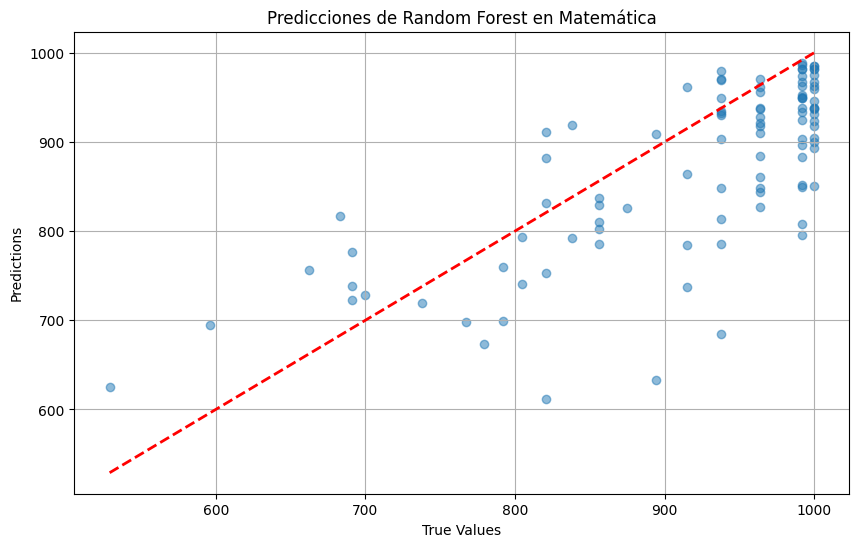

In [86]:
target_column = 'Matemática'
X_train, X_test, y_train, y_test = datasets[target_column]
model = create_model(model_type='random_forest', n_estimators=50, random_state=42)
model, y_pred = train_and_evaluate(model, X_train, y_train, X_test, y_test)
plot_predictions(y_test, y_pred, title=f'Predicciones de Random Forest en {target_column}')

### Crear y entrenar el Stacking Regressor

Stacked Model - Root Mean Squared Error: 83.64, R^2 Score: 0.35


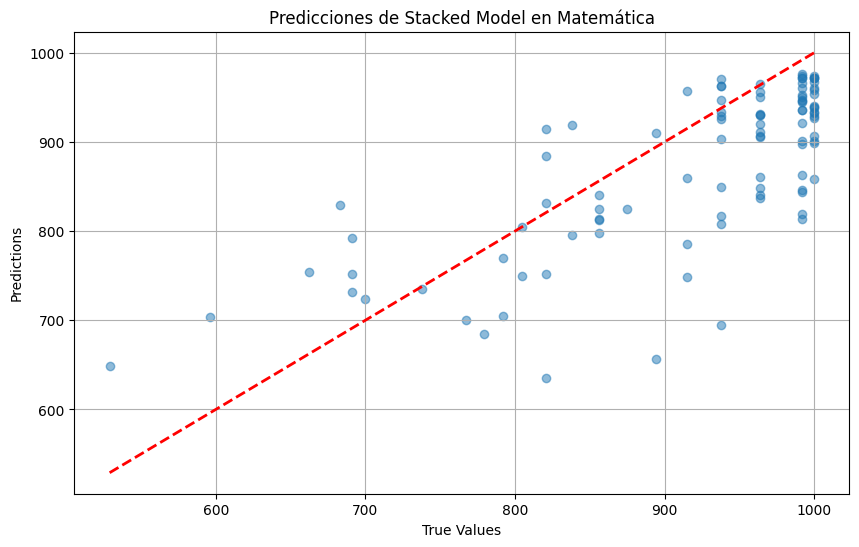

In [93]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=20, random_state=42))
]
final_estimator = BayesianRidge()
stacked_model = create_stacked_model(base_models, final_estimator)
stacked_model, y_pred_stacked = train_stacked_model(stacked_model, X_train, y_train, X_test, y_test)
plot_predictions(y_test, y_pred_stacked, title=f'Predicciones de Stacked Model en {target_column}')

### Graficamos la importancia de las variables

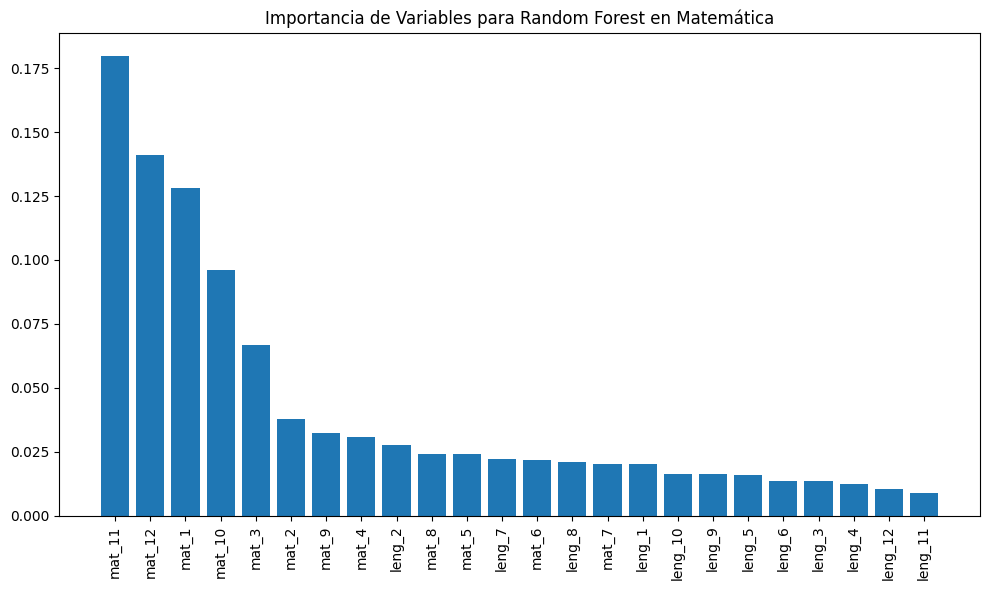

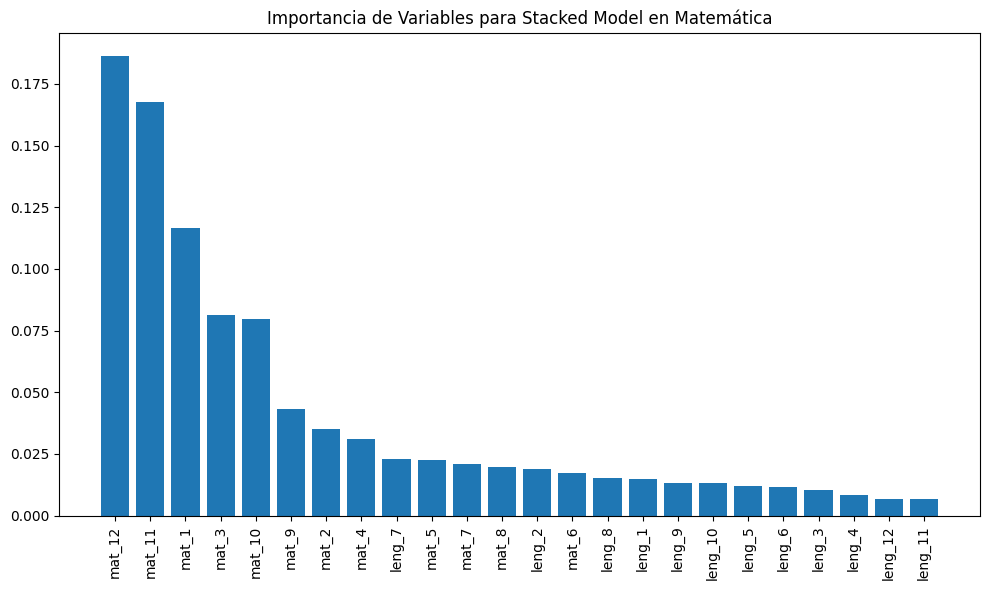

In [94]:
# Plot feature importances for the random forest model
plot_feature_importances(model, X_train.columns, title=f'Importancia de Variables para Random Forest en {target_column}')
# Plot feature importances for the stacked model
plot_stacked_feature_importances(stacked_model, X_train, title=f'Importancia de Variables para Stacked Model en {target_column}')

### Sacar variables de poca importancia

In [120]:
N_vars = 6
X_train, X_test, y_train, y_test = datasets[target_column]
important_columns_rf = X_train.columns[np.argsort(model.feature_importances_)[::-1][:N_vars]]
print(f"Las {N_vars} variables más importantes para el modelo de Random Forest en {target_column} son: {important_columns_rf.tolist()}")
coefs = stacked_model.final_estimator_.coef_
feature_names = X_train.columns
estimators = stacked_model.estimators_
importances = np.zeros(len(feature_names))
# get weighted importances from base models using their coefficients
for i, model in enumerate(estimators):
    if hasattr(model, 'feature_importances_'):
        importances += model.feature_importances_ * coefs[i]
    elif hasattr(model, 'coef_'):
        importances += np.abs(model.coef_) * coefs[i]
indices = np.argsort(importances)[::-1]
important_columns_stacked = feature_names[indices][:N_vars]
print(f"Las {N_vars} variables más importantes para el modelo apilado en {target_column} son: {important_columns_stacked.tolist()}")

Las 6 variables más importantes para el modelo de Random Forest en Matemática son: ['mat_11', 'mat_12', 'mat_1', 'mat_10', 'mat_3', 'mat_2']
Las 6 variables más importantes para el modelo apilado en Matemática son: ['mat_12', 'mat_11', 'mat_1', 'mat_3', 'mat_10', 'mat_9']


Root Mean Squared Error: 82.37, R^2 Score: 0.37


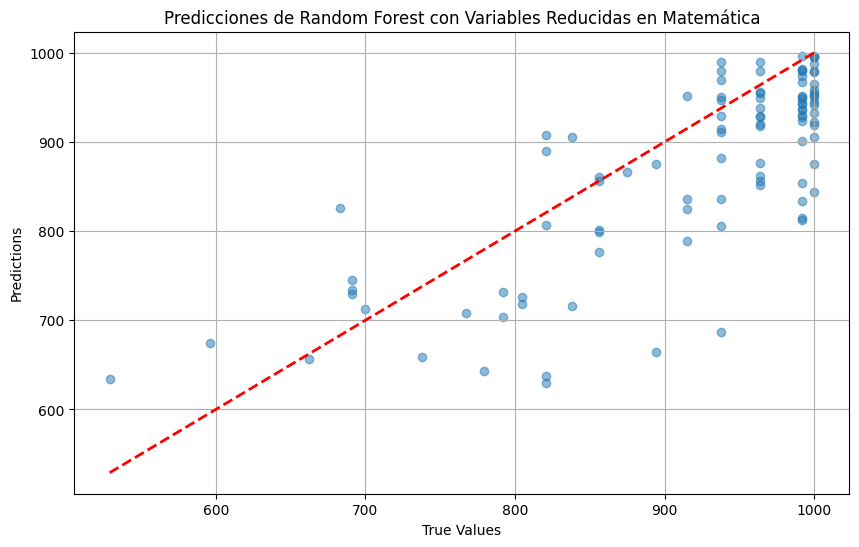

In [121]:
total_columns = important_columns_rf.tolist()
X_train_reduced = X_train[total_columns]
X_test_reduced = X_test[total_columns] if X_test is not None else None
y_train_reduced = y_train
y_test_reduced = y_test
model_reduced = create_model(model_type='random_forest', n_estimators=50, random_state=42)
model_reduced, y_pred_reduced = train_and_evaluate(model_reduced, X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)
plot_predictions(y_test_reduced, y_pred_reduced, title=f'Predicciones de Random Forest con Variables Reducidas en {target_column}')

Stacked Model - Root Mean Squared Error: 77.63, R^2 Score: 0.44


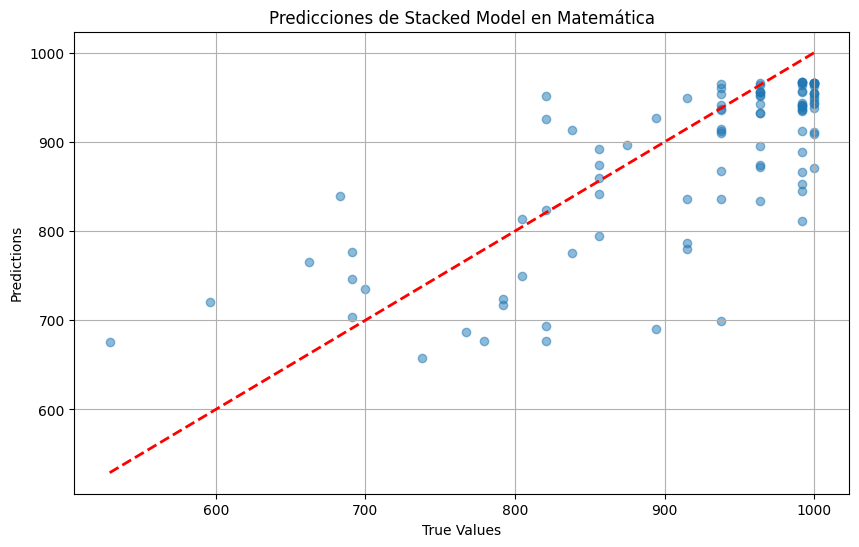

In [122]:
total_columns = important_columns_stacked.tolist()
X_train_reduced = X_train[total_columns]
X_test_reduced = X_test[total_columns] if X_test is not None else None
y_train_reduced = y_train
y_test_reduced = y_test
base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=20, random_state=42))
]
final_estimator = BayesianRidge()
stacked_model = create_stacked_model(base_models, final_estimator)
stacked_model, y_pred_stacked = train_stacked_model(stacked_model, X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)
plot_predictions(y_test_reduced, y_pred_stacked, title=f'Predicciones de Stacked Model en {target_column}')

## Predicciones con todos los datos

In [4]:
dfs = []
data_types = ['pca', 'sepa', 'bloom', 'dificultad']
n_pca_components = 5
for data_type in data_types:
    if data_type == 'pca':
        df, top_indicators_df, components_df = get_data(type=data_type, n_pca_components=n_pca_components, paths=paths)
    else:
        df, _, _ = get_data(type=data_type, paths=paths)
    dfs.append(df)
# merge all dataframes into one
df = merge_data(dfs)
data_types = ['combined']

Datos combinados: 324 filas, 50 columnas
Columnas combinadas: ['RUT', 'Admisión', 'Nombre', 'Matemática', 'C. Lectora', 'Historia', 'Ciencias', 'M2', 'leng_1', 'leng_2', 'leng_3', 'leng_4', 'leng_5', 'leng_6', 'leng_7', 'leng_8', 'leng_9', 'leng_10', 'leng_11', 'leng_12', 'mat_1', 'mat_2', 'mat_3', 'mat_4', 'mat_5', 'mat_6', 'mat_7', 'mat_8', 'mat_9', 'mat_10', 'mat_11', 'mat_12', 'pca4', 'pca1', 'pca0', 'pca3', 'pca2', 'Aplicar', 'Conocer', 'Comprender', 'Crear', 'Evaluar', 'Analizar', '0 - Mediano', '1 - Mediano', '1 - Difícil', '1 - Fácil', '0 - Pendiente', '0 - Fácil', '0 - Difícil']


In [5]:
df_train, df_test = split_data_year(df, year=2025)
target_columns = ['C. Lectora', 'Matemática', 'Historia', 'Ciencias', 'M2']
datasets = {}
for target in target_columns:
    X_train, _, y_train, _ = prepare_data(df_train, target_column=target, test_size=0.0, verbose=True)
    X_test, _, y_test, _ = prepare_data(df_test, target_column=target, test_size=0.0, verbose=True)
    datasets[target] = (X_train, X_test, y_train, y_test)

Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 224
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 100
Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 224
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 100
Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 224
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 100
Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 224
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 100
Cantidad de filas antes de eliminar NaN: 224
Cantidad de filas después de eliminar NaN: 224
Cantidad de filas antes de eliminar NaN: 100
Cantidad de filas después de eliminar NaN: 100


In [66]:
target_column = 'C. Lectora'
X_train, X_test, y_train, y_test = datasets[target_column]
model = create_model(model_type='random_forest', n_estimators=100, random_state=42)
model, y_pred = train_and_evaluate(model, X_train, y_train, X_test, y_test)

# Ahora vamos a crear un modelo apilado con Random Forest y Gradient Boosting como modelos base, y Bayesian Ridge como modelo final.
# es decir, la predicción final se hará con Bayesian Ridge, que tomará las predicciones de los modelos base como entradas.
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]
final_estimator = BayesianRidge()
stacked_model = create_stacked_model(base_models, final_estimator)
stacked_model, y_pred_stacked = train_stacked_model(stacked_model, X_train, y_train, X_test, y_test)

Root Mean Squared Error: 65.16, R^2 Score: 0.51
Stacked Model - Root Mean Squared Error: 66.52, R^2 Score: 0.49


In [67]:
N_vars = 20 # ahora tenemos alrededor de 50 columnas
X_train, X_test, y_train, y_test = datasets[target_column]
important_columns_rf = X_train.columns[np.argsort(model.feature_importances_)[::-1][:N_vars]]
print(f"Las {N_vars} variables más importantes para el modelo de Random Forest en {target_column} son: {important_columns_rf.tolist()}")
coefs = stacked_model.final_estimator_.coef_
feature_names = X_train.columns
estimators = stacked_model.estimators_
importances = np.zeros(len(feature_names))
# get weighted importances from base models using their coefficients
for i, model in enumerate(estimators):
    if hasattr(model, 'feature_importances_'):
        importances += model.feature_importances_ * coefs[i]
    elif hasattr(model, 'coef_'):
        importances += np.abs(model.coef_) * coefs[i]
indices = np.argsort(importances)[::-1]
important_columns_stacked = feature_names[indices][:N_vars]
print(f"Las {N_vars} variables más importantes para el modelo apilado en {target_column} son: {important_columns_stacked.tolist()}")

Las 20 variables más importantes para el modelo de Random Forest en C. Lectora son: ['1 - Difícil', '1 - Mediano', 'pca3', 'leng_5', 'leng_1', '1 - Fácil', 'leng_12', 'leng_11', 'leng_10', 'leng_3', 'leng_8', 'pca0', 'mat_8', 'mat_2', 'Comprender', 'mat_5', 'pca1', 'leng_2', '0 - Mediano', 'Evaluar']
Las 20 variables más importantes para el modelo apilado en C. Lectora son: ['1 - Difícil', '1 - Mediano', 'leng_5', 'pca3', 'leng_12', 'leng_1', '1 - Fácil', 'leng_11', 'leng_10', 'leng_3', 'pca0', 'mat_8', 'leng_8', 'mat_2', 'pca1', 'Comprender', 'leng_2', 'mat_5', '0 - Mediano', 'Evaluar']


In [68]:
total_columns = important_columns_rf.tolist()
X_train_reduced = X_train[total_columns]
X_test_reduced = X_test[total_columns] if X_test is not None else None
y_train_reduced = y_train
y_test_reduced = y_test
model_reduced = create_model(model_type='random_forest', n_estimators=100, random_state=42)
model_reduced, y_pred_reduced = train_and_evaluate(model_reduced, X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)

total_columns = important_columns_stacked.tolist()
X_train_reduced = X_train[total_columns]
X_test_reduced = X_test[total_columns] if X_test is not None else None
y_train_reduced = y_train
y_test_reduced = y_test
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]
final_estimator = BayesianRidge()
stacked_model = create_stacked_model(base_models, final_estimator)
stacked_model, y_pred_stacked = train_stacked_model(stacked_model, X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)

Root Mean Squared Error: 66.28, R^2 Score: 0.50
Stacked Model - Root Mean Squared Error: 67.29, R^2 Score: 0.48


In [49]:
target_column = 'Matemática'
X_train, X_test, y_train, y_test = datasets[target_column]
model = create_model(model_type='random_forest', n_estimators=200, random_state=42)
model, y_pred = train_and_evaluate(model, X_train, y_train, X_test, y_test)

base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
]
final_estimator = BayesianRidge()
stacked_model = create_stacked_model(base_models, final_estimator)
stacked_model, y_pred_stacked = train_stacked_model(stacked_model, X_train, y_train, X_test, y_test)

Root Mean Squared Error: 85.36, R^2 Score: 0.32
Stacked Model - Root Mean Squared Error: 84.19, R^2 Score: 0.34


In [50]:
N_vars = 20
X_train, X_test, y_train, y_test = datasets[target_column]
important_columns_rf = X_train.columns[np.argsort(model.feature_importances_)[::-1][:N_vars]]
print(f"Las {N_vars} variables más importantes para el modelo de Random Forest en {target_column} son: {important_columns_rf.tolist()}")
coefs = stacked_model.final_estimator_.coef_
feature_names = X_train.columns
estimators = stacked_model.estimators_
importances = np.zeros(len(feature_names))
# get weighted importances from base models using their coefficients
for i, model in enumerate(estimators):
    if hasattr(model, 'feature_importances_'):
        importances += model.feature_importances_ * coefs[i]
    elif hasattr(model, 'coef_'):
        importances += np.abs(model.coef_) * coefs[i]
indices = np.argsort(importances)[::-1]
important_columns_stacked = feature_names[indices][:N_vars]
print(f"Las {N_vars} variables más importantes para el modelo apilado en {target_column} son: {important_columns_stacked.tolist()}")

Las 20 variables más importantes para el modelo de Random Forest en Matemática son: ['0 - Mediano', 'mat_12', 'mat_10', 'mat_1', 'mat_11', '1 - Difícil', '0 - Difícil', 'leng_2', 'mat_3', 'leng_8', 'mat_4', 'pca3', 'leng_1', '1 - Mediano', 'pca4', 'mat_9', '0 - Fácil', 'Comprender', 'mat_8', 'pca2']
Las 20 variables más importantes para el modelo apilado en Matemática son: ['0 - Mediano', 'mat_12', 'mat_10', 'mat_1', 'mat_11', '0 - Difícil', '1 - Difícil', 'mat_3', 'leng_2', 'leng_8', 'mat_4', 'leng_1', '1 - Mediano', 'pca3', 'pca4', 'Comprender', 'mat_9', 'pca2', 'pca0', 'leng_9']


In [54]:
total_columns = important_columns_rf.tolist()
X_train_reduced = X_train[total_columns]
X_test_reduced = X_test[total_columns] if X_test is not None else None
y_train_reduced = y_train
y_test_reduced = y_test
model_reduced = create_model(model_type='random_forest', n_estimators=100, random_state=42)
model_reduced, y_pred_reduced = train_and_evaluate(model_reduced, X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)

total_columns = important_columns_stacked.tolist()
X_train_reduced = X_train[total_columns]
X_test_reduced = X_test[total_columns] if X_test is not None else None
y_train_reduced = y_train
y_test_reduced = y_test
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]
final_estimator = BayesianRidge()
stacked_model = create_stacked_model(base_models, final_estimator)
stacked_model, y_pred_stacked = train_stacked_model(stacked_model, X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)

Root Mean Squared Error: 82.69, R^2 Score: 0.36
Stacked Model - Root Mean Squared Error: 78.64, R^2 Score: 0.42
